# 데이터 분석

## 최종 코드

### 형태소 분리

In [66]:
def df_to_string(df, column):
    """DataFrame을 String으로 변환하는 함수"""
    df_list = df[column].to_list()
    df_string = ''.join(str(s) for s in df_list)
    
    return df_string

#### 명사 분리

In [67]:
# Setting
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_noun_extractor(text):
    """kiwipiepy패키지를 이용해서 명사를 분류하는 함수"""
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

def wordcloud_noun(noun_text):
    """워드클라우드를 통해 시각화하는 함수"""
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    plt.show()

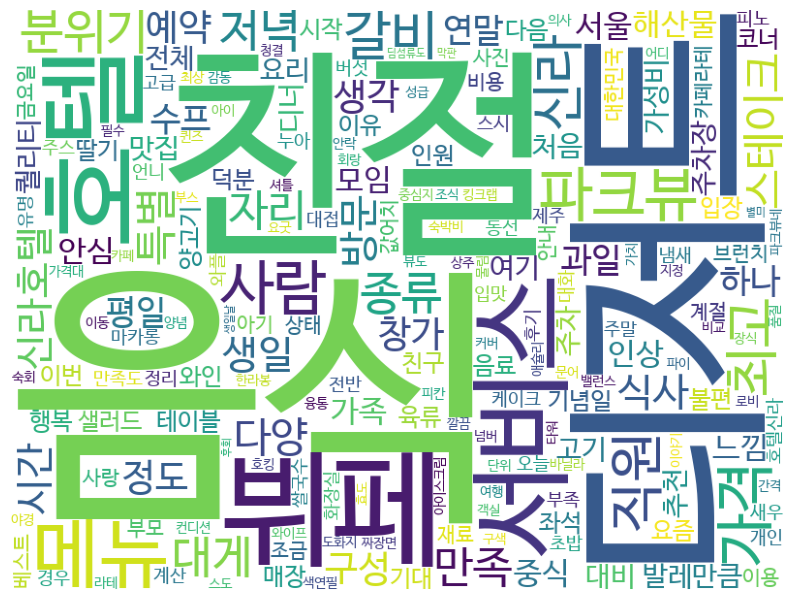

In [47]:
# 실행
s_hotel_buffet_review_outlier = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
s_hotel_buffet_review_outlier_string = df_to_string(s_hotel_buffet_review_outlier, "Review_Text")

s_hotel_buffet_review_nouns = kiwi_noun_extractor(s_hotel_buffet_review_outlier_string)
wordcloud_noun(s_hotel_buffet_review_nouns)

#### 형용사/동사 분리

In [68]:
# Setting
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    """kiwipiepy패키지를 이용해서 형용사,동사를 분류하는 함수"""
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

def wordcloud_verb_adj(verb_adj_text):
    """워드클라우드를 통해 시각화하는 함수"""
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    plt.show()

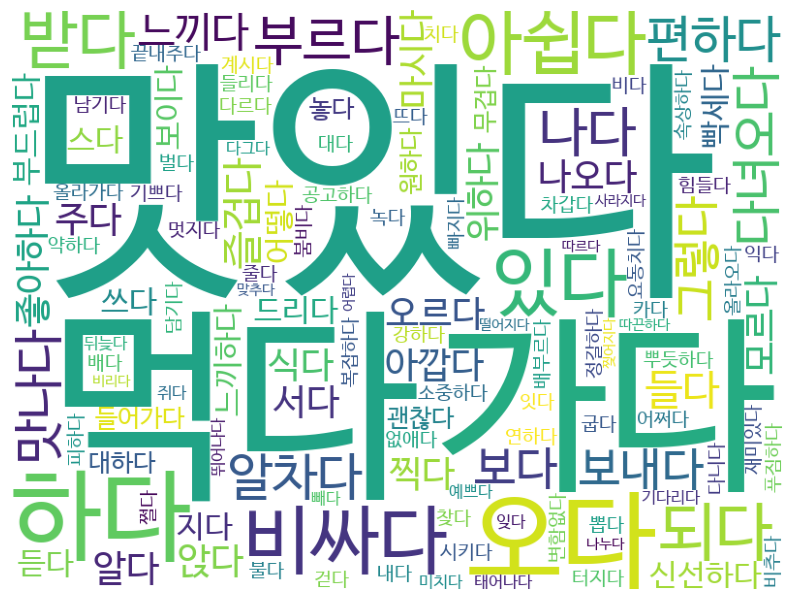

In [46]:
# 실행
s_hotel_buffet_review_outlier = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
s_hotel_buffet_review_outlier_string = df_to_string(s_hotel_buffet_review_outlier, "Review_Text")

s_hotel_buffet_review_verb_adj = kiwi_verb_adj_extractor(s_hotel_buffet_review_outlier_string)
wordcloud_verb_adj(s_hotel_buffet_review_verb_adj)

### '만족도', '맛', '서비스', '가격' 총 네가지로 나누어 긍정/부정 분류

In [56]:
# Setting
import os
import pandas as pd
import json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI



True

In [69]:
class MyChain:
    """chain을 만들어 프롬프트와 연결하는 클래스"""
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    """분류된 json형식을 딕셔너리로 바꾸는 함수"""
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

def save_parse_reviews(df, chain):
    """분류된 데이터들을 데이터프레임에 저장하는 함수"""
    temp = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
    for sentence in df["Review_Text"]:
        emo_eval = chain.invoke(sentence)
        test_result = parsing(emo_eval.content)
        temp["만족도"].append(test_result["만족도"])
        temp["맛"].append(test_result["맛"])
        temp["서비스"].append(test_result["서비스"])
        temp["가격"].append(test_result["가격"])

    df["만족도"] = temp["만족도"]
    df["맛"] = temp["맛"]
    df["서비스"] = temp["서비스"]
    df["가격"] = temp["가격"]
    
    df.to_csv("./S_hotel_buffet_review_parse.csv")
    return df

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": "긍정/부정/-",
    "서비스": "긍정/부정/-",
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""


In [63]:
# 실행
s_hotel_buffet_review_outlier = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
s_hotel_buffet_review_outlier = s_hotel_buffet_review_outlier.drop('Unnamed: 0', axis = 1)

chain = MyChain(template=template)

s_hotel_buffet_parse_review = save_parse_reviews(s_hotel_buffet_review_outlier, chain)

In [64]:
s_hotel_buffet_parse_review.head(10)

,UserID,Review_Text,Date,NumberOfVisit,만족도,맛,서비스,가격
0,illiiilillil,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,2024년 5월 19일 일요일,1번째 방문,긍정,긍정,긍정,-
1,shooooooo,종류도 알차게 많고 다 맛있어요,2024년 6월 7일 금요일,1번째 방문,긍정,긍정,-,-
2,Choigo다,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,2024년 3월 3일 일요일,1번째 방문,긍정,-,긍정,부정
3,shekyh,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,2024년 2월 3일 토요일,1번째 방문,긍정,부정,긍정,-
4,이진욱쨩,항상 친절하시고 음식도 맛있네요,2024년 4월 21일 일요일,2번째 방문,긍정,긍정,긍정,-
5,KSL1,분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...,2023년 12월 13일 수요일,1번째 방문,긍정,긍정,-,부정
6,juehhhhh,부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...,2024년 2월 25일 일요일,1번째 방문,긍정,긍정,-,부정
7,Reinyourheart,신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...,2024년 1월 9일 화요일,1번째 방문,긍정,긍정,-,부정
8,블리랩,평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...,2023년 11월 14일 화요일,1번째 방문,긍정,긍정,긍정,-
9,미국주식왕,네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집,2024년 3월 10일 일요일,1번째 방문,긍정,긍정,-,부정


---

## 연습

In [13]:
import pandas as pd

In [15]:
temp_review_strlength = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")

In [16]:
review_strlist = temp_review_strlength["Review_Text"].to_list()
review_string = ''.join(str(s) for s in review_strlist)

In [17]:
review_string[:20]

'직원 분들 너무 친절하시고 음식 맛은'

---

### 1. 형태소 분리

1. 명사 분류하기
    - 시각화
2. 동사, 형용사 분류하기
    - 시각화

#### 1. 명사

In [7]:
# 1. 명사 분류하기
# from konlpy.tag import Okt
# okt = Okt()

# def okt_noun_extractor(text):
#     return okt.nouns(text)

In [30]:
# kiwi 명사 추출 함수
from kiwipiepy import Kiwi
kiwi = Kiwi()
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [31]:
# review_nouns = okt_noun_extractor(review_string)
review_nouns = kiwi_noun_extractor(review_string)

In [32]:
# - 명사 시각화 하기
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    plt.show()

##### 문제점: `okt`를 사용시 명사라고 보기 어려운 것도 명사로 인식되어 나오게 됨.

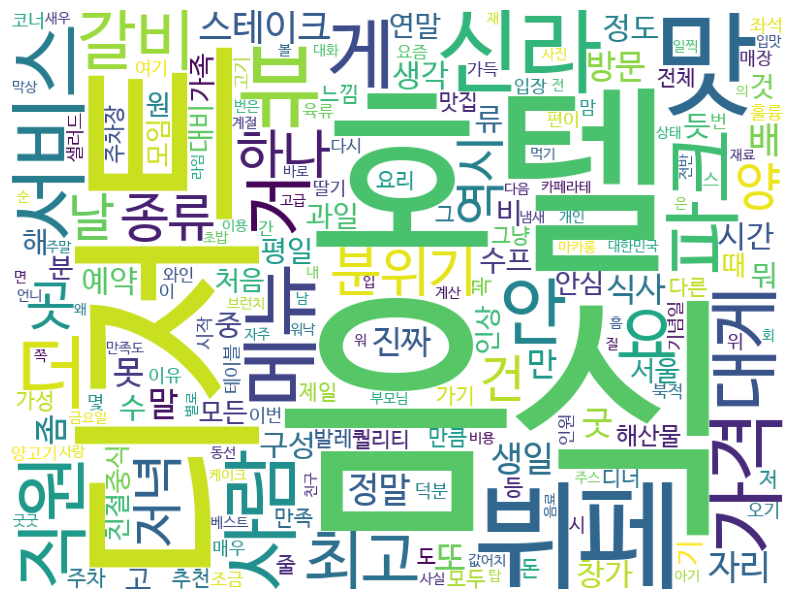

In [11]:
wordcloud_noun(review_nouns)

- 위의 명사를 통해 디저트, 호텔, 음식에 대한 키워드가 많이 나왔고, 메뉴, 사람, 가격등의 단어가 분포가 그다음으로 많음.

##### 해결법: `Kiwipiepy`를 사용하여 명사를 분류하니 okt보다 명사로 잘 분류되어 시각화 잘됨.

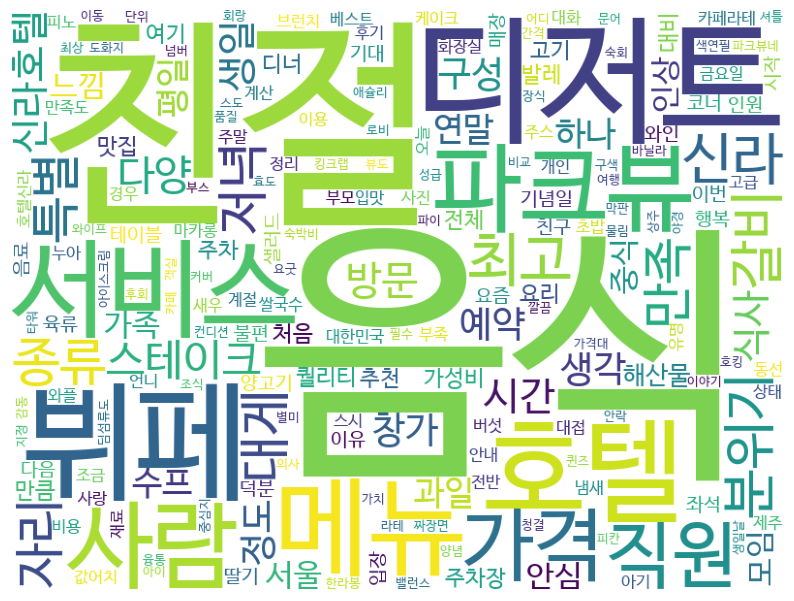

In [33]:
wordcloud_noun(review_nouns)

- 위의 워드클라우드를 통해 `친절`, `음식` 등의 단어가 제일 많이 분포되어 있고 그뒤로 `서비스`, `디저트`,`분위기`등의 단어들이 분포가 된다.

#### 2. 동사 / 형용사

In [18]:
# 동사 / 형용사 분류하기

def okt_adj_verb_extractor(text):
    results = []
    result = okt.pos(text)
    
    for token, pos in result:
        if len(token) != 1 and pos.startswith('Adj'): #or pos.startswith('Verb'):
            results.append(token)
    return results

In [37]:
# 동사, 형용사 분류하기
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_verb_adj_extractor(text):
    results = []
    result = kiwi.analyze(text)
    
    for token,pos,_,_ in result[0][0]:
        if len(token) != 1 and pos.startswith('VA') or pos.startswith('VV'):
            results.append(token)
    f_results = list(map(lambda x : x + '다',results))
    return f_results

In [38]:
# review_adj_verb_okt = okt_adj_verb_extractor(review_string)
review_adj_verb_temp = kiwi_verb_adj_extractor(review_string)
# review_adj_verb = list(map(lambda x : x + '다',results))

In [34]:
# review_adj_verb_temp

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_verb_adj(verb_adj_text):
    cnt = len(verb_adj_text)
    counts = Counter(verb_adj_text)
    tags_verb_adj = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_verb_adj = wc.generate_from_frequencies(dict(tags_verb_adj))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_verb_adj)
    plt.show()

##### 문제점: `okt`를 사용하니 같은 의미지만 다른 형태로 나오게 되어 시각화할시 중복되어 나오게 되어 본질을 흐림.

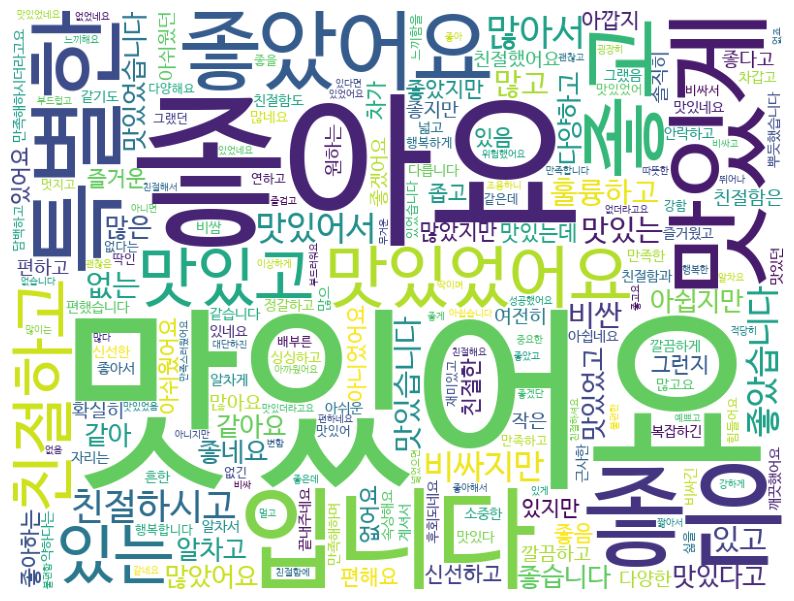

In [35]:
wordcloud_verb_adj(review_adj_verb_okt)

##### 해결법: `Kiwipiepy`를 사용하니 중복되는 단어 없이 분류가 잘되어 시각화가 잘나타나짐.

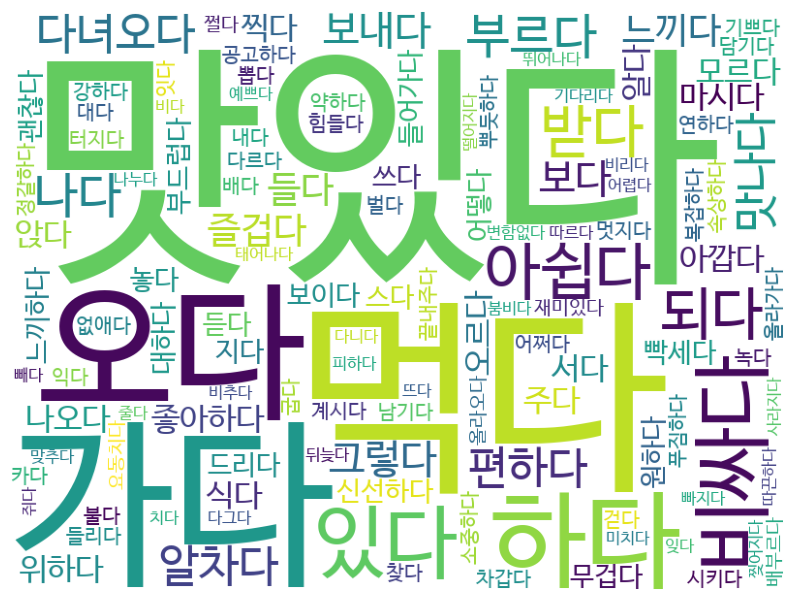

In [40]:
wordcloud_verb_adj(review_adj_verb_temp)

---

### 2. 네이버 키워드 리뷰를 통해 '만족도', '맛', '서비스', '가격' 총 네가지로 나누어 긍정/부정 분류

In [48]:
import os
import pandas as pd
import json
from dotenv import load_dotenv

load_dotenv()

True

In [49]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

#### 문제점1: 각 음식에 대한 긍정/ 부정 확인이 필요하다고 생각함

#### 해결방법: 프롬프트로 각 음식에 대한 긍정/ 부정으로 출력하게 한다.

In [7]:
from langchain_core.prompts import PromptTemplate

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 긍정적인 평가와 부정적인 평가가 함께 있는 경우, 
  모든 '맛'평가의 대상음식과 긍정/부정적인 평가를 다 출력하세요
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": '음식1 긍정/부정/-, 음식2 긍정/부정/-, ...'
    "서비스": "긍정/부정/-"
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | llm

In [9]:
temp_test = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
# temp_test_review = temp_test_review.drop('Unnamed: 0', axis = 1)
for sentence in temp_test_review["Review_Text"]:
    emo_eval = chain.invoke({"sentence":sentence})
    test_result = json.loads(emo_eval.content)
    temp_test["만족도"].append(test_result["만족도"])
    temp_test["맛"].append(test_result["맛"])
    temp_test["서비스"].append(test_result["서비스"])
    temp_test["가격"].append(test_result["가격"])

In [11]:
temp_test_review["만족도"] = temp_test["만족도"]
temp_test_review["맛"] = temp_test["맛"]
temp_test_review["서비스"] = temp_test["서비스"]
temp_test_review["가격"] = temp_test["가격"]

#### 문제점2: 프롬프트에 너무 많은 일을 시키게 되어 과부하 비슷한 일이 걸림.

In [12]:
temp_test_review.head()

,UserID,Review_Text,Date,NumberOfVisit,만족도,맛,서비스,가격
0,illiiilillil,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,2024년 5월 19일 일요일,1번째 방문,긍정,"고기 부정, 샐러드 긍정",긍정,-
1,shooooooo,종류도 알차게 많고 다 맛있어요,2024년 6월 7일 금요일,1번째 방문,긍정,"고기 부정, 샐러드 긍정",-,-
2,Choigo다,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,2024년 3월 3일 일요일,1번째 방문,긍정,-,긍정,부정
3,shekyh,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,2024년 2월 3일 토요일,1번째 방문,긍정,"대게 부정, 짜장면 부정, 양갈비 긍정, 딸기 긍정, 한라봉 긍정",긍정,-
4,이진욱쨩,항상 친절하시고 음식도 맛있네요,2024년 4월 21일 일요일,2번째 방문,긍정,음식 부정,긍정,-


#### 헤결방법: 원래는 멀티체인을 이용해야하지만 이건 어디까지나 실습용이기에 그냥 프롬프트로 분류 되는데로 하기로 함.

In [18]:
from langchain_core.prompts import PromptTemplate

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": "긍정/부정/-",
    "서비스": "긍정/부정/-",
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | llm

In [19]:
temp_test = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
# temp_test_review = temp_test_review.drop('Unnamed: 0', axis = 1)
for sentence in temp_test_review["Review_Text"]:
    emo_eval = chain.invoke({"sentence":sentence})
    test_result = json.loads(emo_eval.content)
    temp_test["만족도"].append(test_result["만족도"])
    temp_test["맛"].append(test_result["맛"])
    temp_test["서비스"].append(test_result["서비스"])
    temp_test["가격"].append(test_result["가격"])

In [21]:
temp_test_review = temp_review.copy()
temp_test_review["만족도"] = temp_test["만족도"]
temp_test_review["맛"] = temp_test["맛"]
temp_test_review["서비스"] = temp_test["서비스"]
temp_test_review["가격"] = temp_test["가격"]

In [22]:
temp_test_review.head(10)

,Unnamed: 0,UserID,Review_Text,Date,NumberOfVisit,만족도,맛,서비스,가격
0,0,illiiilillil,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,2024년 5월 19일 일요일,1번째 방문,긍정,긍정,긍정,-
1,1,shooooooo,종류도 알차게 많고 다 맛있어요,2024년 6월 7일 금요일,1번째 방문,긍정,긍정,-,-
2,2,Choigo다,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,2024년 3월 3일 일요일,1번째 방문,긍정,-,긍정,부정
3,3,shekyh,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,2024년 2월 3일 토요일,1번째 방문,긍정,부정,긍정,-
4,4,이진욱쨩,항상 친절하시고 음식도 맛있네요,2024년 4월 21일 일요일,2번째 방문,긍정,긍정,긍정,-
5,5,KSL1,분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...,2023년 12월 13일 수요일,1번째 방문,긍정,긍정,-,부정
6,6,juehhhhh,부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...,2024년 2월 25일 일요일,1번째 방문,긍정,긍정,-,-
7,7,Reinyourheart,신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...,2024년 1월 9일 화요일,1번째 방문,긍정,긍정,-,부정
8,8,블리랩,평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...,2023년 11월 14일 화요일,1번째 방문,긍정,긍정,긍정,-
9,9,미국주식왕,네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집,2024년 3월 10일 일요일,1번째 방문,긍정,긍정,-,-


#### 클래스를 이용한 프롬프트

In [52]:
class MyChain:
    def __init__(self, template):
        self.llm = ChatOpenAI()
        self.prompt = PromptTemplate.from_template(template)
        
    def invoke(self, review_text):
        
        input_data = {"sentence": review_text}
        
        result = (self.prompt | self.llm).invoke(input_data)
        
        return result
    
def parsing(output):
    try:
        result_dict = json.loads(output)
    except json.JSONDecodeError:
        result_dict = {}
    return result_dict

load_dotenv()

template = """\
# INSTRUCTION
- 당신은 긍/부정 분류기입니다.
- 각 대상 '만족도', '맛', '서비스', '가격'에 대한 평가가 긍정적인지 부정적인지를 분류하세요.
- 대상에 대한 평가가 없는 경우 '-'을 표시하세요.
- 예시를 보고 결과를 다음과 같은 딕셔너리 형식으로 출력하세요:

    "만족도": "긍정/부정/-",
    "맛": "긍정/부정/-",
    "서비스": "긍정/부정/-",
    "가격": "긍정/부정/-"

# SENTENCE: {sentence}
"""
temp_review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Preprocessing/S_hotel_buffet_review_IQR.csv")
temp_test_review2 = temp_review.copy()

chain = MyChain(template=template)

temp_test = {"만족도": [], "맛":[], "서비스":[], "가격":[]}
for sentence in temp_test_review2["Review_Text"]:
    emo_eval = chain.invoke(sentence)
    test_result = parsing(emo_eval.content)
    temp_test["만족도"].append(test_result["만족도"])
    temp_test["맛"].append(test_result["맛"])
    temp_test["서비스"].append(test_result["서비스"])
    temp_test["가격"].append(test_result["가격"])


temp_test_review2["만족도"] = temp_test["만족도"]
temp_test_review2["맛"] = temp_test["맛"]
temp_test_review2["서비스"] = temp_test["서비스"]
temp_test_review2["가격"] = temp_test["가격"]

In [55]:
temp_test_review2.head(10)

,Unnamed: 0,UserID,Review_Text,Date,NumberOfVisit,만족도,맛,서비스,가격
0,0,illiiilillil,직원 분들 너무 친절하시고 음식 맛은 대한민국 호텔 뷔페 넘버 원인데 말해 뭐 해입...,2024년 5월 19일 일요일,1번째 방문,긍정,긍정,긍정,-
1,1,shooooooo,종류도 알차게 많고 다 맛있어요,2024년 6월 7일 금요일,1번째 방문,긍정,긍정,-,긍정
2,2,Choigo다,신라호텔 파크뷰 조식 이용했습니다 11층이라 뷰도 훌륭하고 객실 컨디션이나 청결 서...,2024년 3월 3일 일요일,1번째 방문,긍정,-,긍정,부정
3,3,shekyh,창가 자리는 보기만 하고 부스 좌석 안내받음 안락하고 좋았어요 대게는 차갑고 짜고 ...,2024년 2월 3일 토요일,1번째 방문,긍정,부정,긍정,-
4,4,이진욱쨩,항상 친절하시고 음식도 맛있네요,2024년 4월 21일 일요일,2번째 방문,긍정,긍정,긍정,-
5,5,KSL1,분위기도 너무 좋고 음식 하나하나 다 만족해하며 맛있게 먹고 왔습니다 샐러드 킹크랩...,2023년 12월 13일 수요일,1번째 방문,긍정,긍정,-,-
6,6,juehhhhh,부모님 효도 여행으로 방문 신라호텔 호킹 스도 시켜드리고 뷔페도 먹었는데 만족해하시...,2024년 2월 25일 일요일,1번째 방문,긍정,긍정,-,부정
7,7,Reinyourheart,신라호텔이 호텔 뷔페 중 1등이라고 생각하는데 이번에도 그 생각이 공고해졌습니다 음...,2024년 1월 9일 화요일,1번째 방문,긍정,긍정,-,부정
8,8,블리랩,평일 저녁 식사하러 방문하였습니다 서울에 있는 거의 모든 호텔 뷔페는 다 가 봤지만...,2023년 11월 14일 화요일,1번째 방문,긍정,긍정,긍정,-
9,9,미국주식왕,네 번째 방문만에 창가 자리에서 먹게 되어서 기쁨 그리고 카페라테 맛집,2024년 3월 10일 일요일,1번째 방문,긍정,긍정,긍정,-


### 3. 긍/부정으로 분류된 데이터들을 시각화하여 분석하기/나타내기

#### 사람들이 리뷰글로 얼마나 많은 긍/부정 평가를 했는지 막대그래프를 사용하여 시각화

In [70]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

##### 각 카테고리별 긍/부정 개수 구하기

In [71]:
satisfaction_emote = temp_review["만족도"].value_counts()
taste_emote = temp_review["맛"].value_counts()
service_emote = temp_review["서비스"].value_counts()
price_emote = temp_review["가격"].value_counts()

In [72]:
print(satisfaction_emote)
print(taste_emote)
print(service_emote)
print(price_emote)

만족도
긍정    150
부정     11
-      10
Name: count, dtype: int64
맛
긍정    140
-      25
부정      6
Name: count, dtype: int64
서비스
-     93
긍정    67
부정    11
Name: count, dtype: int64
가격
-     100
부정     59
긍정     12
Name: count, dtype: int64


##### 막대그래프 시각화

In [73]:
# 한글 글꼴 설정
import matplotlib.pyplot as plt
import numpy as np
font_path = 'C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
font_name = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name

In [74]:
def review_emote_bar(emote1,emote2,emote3,emote4):
    """카테고리 4개인 막대그래프 만드는 함수"""
    x = np.arange(4)
    
    satisf_Aemo = satisfaction_emote["긍정"] + satisfaction_emote["부정"]
    taste_Aemo = taste_emote["긍정"] + taste_emote["부정"]
    service_Aemo = service_emote["긍정"] + service_emote["부정"]
    price_Aemo = price_emote["긍정"] + price_emote["부정"]
    
    y_axis = [satisf_Aemo,taste_Aemo,service_Aemo,price_Aemo]
    x_axis = ["만족도","맛","서비스","가격"]
    plt.bar(x,y_axis)
    plt.xticks(x, x_axis)
    plt.show()

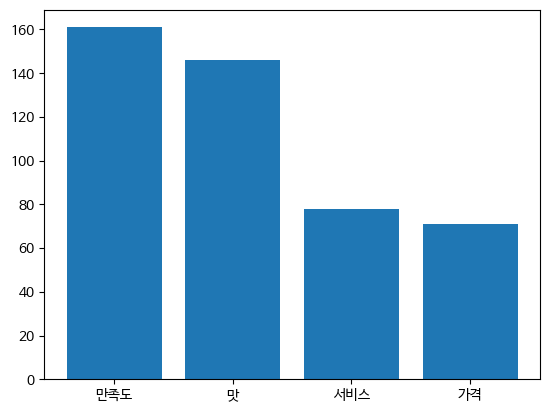

In [75]:
review_emote_bar(satisfaction_emote,taste_emote,service_emote,price_emote)

#### 긍정 평가가 많은 카테고리, 부정 평가가 많은 카테고리 확인

- 긍정 평가가 많은 카테고리 = `만족도`
- 부정 평가가 많은 카테고리 = `가격`

#### 긍/부정평가가 많은 카테고리의 각 긍/부정 리뷰글만 추출하여 데이터 프레임 생성

##### 긍정이 많은 카테고리의 긍정 리뷰글만 추출

In [87]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

In [88]:
satisfy_reviews = {"긍정":[]}
# 만족도항목에 긍정이라 평가된 리뷰글만 추출
for i in range(len(temp_review)):
    if temp_review["만족도"][i] == "긍정":
        satisfy_reviews["긍정"].append(temp_review["Review_Text"][i])

In [89]:
# 리뷰글만 빼내어 문자열로 받기

for key, value in satisfy_reviews.items():
    satisfy_reviews[key] = ', '.join(value)
    
satisfy_positive_string = satisfy_reviews.get("긍정")
print(satisfy_positive_string[:20])

직원 분들 너무 친절하시고 음식 맛은


##### 부정이 많은 카테고리의 부정 리뷰글만 추출

In [90]:
import pandas as pd

review = pd.read_csv("C:/Users/pps/Desktop/Restaurant_Review/Data_Analyze/S_hotel_buffet_review_parse.csv")
temp_review = review.copy()

In [91]:
price_reviews = {"부정":[]}
# 가격항목에 부정이라 평가된 리뷰글만 추출
for i in range(len(temp_review)):
    if temp_review["가격"][i] == "부정":
        price_reviews["부정"].append(temp_review["Review_Text"][i])

In [92]:
# 리뷰글만 빼내어 문자열로 받기

for key, value in price_reviews.items():
    price_reviews[key] = ', '.join(value)
    
price_negative_string = price_reviews.get("부정")
print(price_negative_string[:20])

신라호텔 파크뷰 조식 이용했습니다 1


#### 각각의 긍/부정 리뷰글들의 명사 추출 및 시각화

##### 긍정 리뷰글의 명사추출 및 시각화

In [95]:
# 명사 추출
from kiwipiepy import Kiwi

kiwi = Kiwi()
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [94]:
satisfy_reviews_noun = kiwi_noun_extractor(satisfy_positive_string)

In [96]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    plt.show()

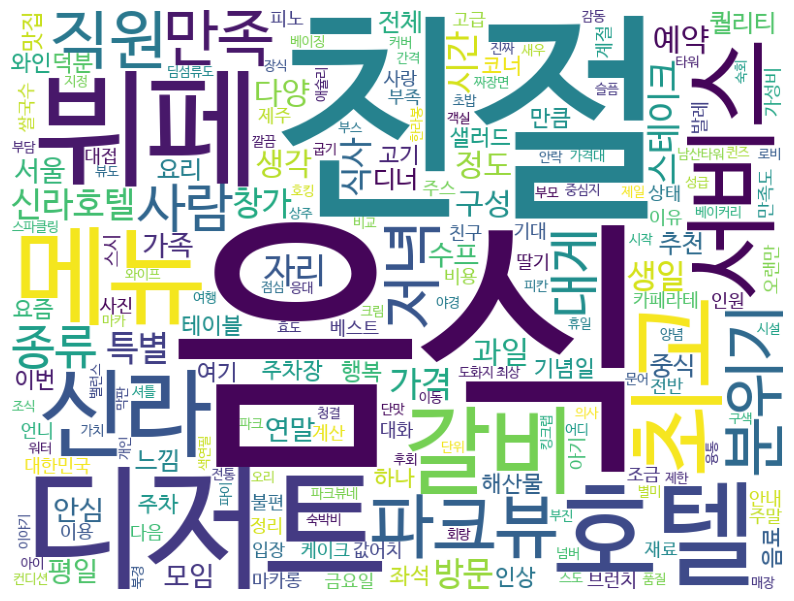

In [97]:
wordcloud_noun(satisfy_reviews_noun)

##### 부정리뷰글의 명사추출 및 시각화

In [98]:
# 명사 추출
from kiwipiepy import Kiwi

kiwi = Kiwi()
def kiwi_noun_extractor(text):
    results = []
    result = kiwi.analyze(text)
    for token, pos, _, _ in result[0][0]:
        # kiwi의 태그 목록 체언:
        # NNG: 일반 명사, NNP: 고유 명사, NNB: 의존 명사, NR: 수사, NP: 대명사
        if len(token) != 1 and pos.startswith('N'): #or pos.startswith('SL'):
            results.append(token)
    return results

In [99]:
price_reviews_noun = kiwi_noun_extractor(price_negative_string)

In [100]:
# 워드클라우드 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def wordcloud_noun(noun_text):
    cnt = len(noun_text)
    counts = Counter(noun_text)
    tags_noun = counts.most_common(cnt)
    wc = WordCloud(font_path='C:/Users/pps/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf', background_color='white', width=800, height=600)
    cloud_noun = wc.generate_from_frequencies(dict(tags_noun))
    
    plt.figure(figsize = (10, 8))
    plt.axis('off')
    plt.imshow(cloud_noun)
    plt.show()

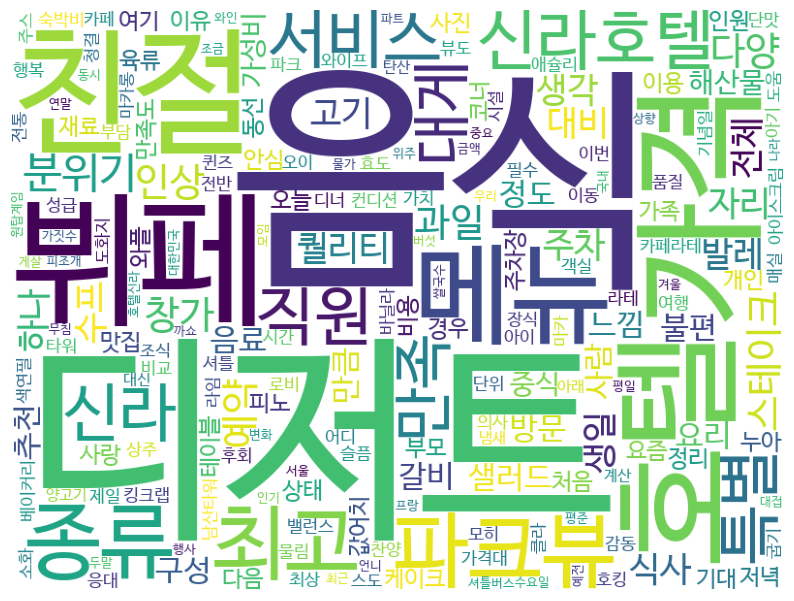

In [101]:
wordcloud_noun(price_reviews_noun)